In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 28 days


In [2]:
# %pdb

In [3]:
debug = True # global var to control debugging

In [4]:
import theano

import theano.tensor as TT

In [5]:
#
# These are taken from https://github.com/mila-udem/blocks
# 

class Constant():
    """Initialize parameters to a constant.
    The constant may be a scalar or a :class:`~numpy.ndarray` of any shape
    that is broadcastable with the requested parameter arrays.
    Parameters
    ----------
    constant : :class:`~numpy.ndarray`
        The initialization value to use. Must be a scalar or an ndarray (or
        compatible object, such as a nested list) that has a shape that is
        broadcastable with any shape requested by `initialize`.
    """
    def __init__(self, constant):
        self._constant = numpy.asarray(constant)

    def generate(self, rng, shape):
        dest = numpy.empty(shape, dtype=np.float32)
        dest[...] = self._constant
        return dest


class IsotropicGaussian():
    """Initialize parameters from an isotropic Gaussian distribution.
    Parameters
    ----------
    std : float, optional
        The standard deviation of the Gaussian distribution. Defaults to 1.
    mean : float, optional
        The mean of the Gaussian distribution. Defaults to 0
    Notes
    -----
    Be careful: the standard deviation goes first and the mean goes
    second!
    """
    def __init__(self, std=1, mean=0):
        self._mean = mean
        self._std = std

    def generate(self, rng, shape):
        m = rng.normal(self._mean, self._std, size=shape)
        return m.astype(np.float32)


class Uniform():
    """Initialize parameters from a uniform distribution.
    Parameters
    ----------
    mean : float, optional
        The mean of the uniform distribution (i.e. the center of mass for
        the density function); Defaults to 0.
    width : float, optional
        One way of specifying the range of the uniform distribution. The
        support will be [mean - width/2, mean + width/2]. **Exactly one**
        of `width` or `std` must be specified.
    std : float, optional
        An alternative method of specifying the range of the uniform
        distribution. Chooses the width of the uniform such that random
        variates will have a desired standard deviation. **Exactly one** of
        `width` or `std` must be specified.
    """
    def __init__(self, mean=0., width=None, std=None):
        if (width is not None) == (std is not None):
            raise ValueError("must specify width or std, "
                             "but not both")
        if std is not None:
            # Variance of a uniform is 1/12 * width^2
            self._width = numpy.sqrt(12) * std
        else:
            self._width = width
        self._mean = mean

    def generate(self, rng, shape):
        w = self._width / 2
        m = rng.uniform(self._mean - w, self._mean + w, size=shape)
        return m.astype(np.float32)

In [6]:
def default(var, val):
    if var is None:
        return val
    else:
        return var

# LSTM implementation in Theano

Theano fully supports recurrent neural networks. One typically needs only to provide an implementation of a single step of the recurrency.

Please read about the scan function which is used to implement the loops: http://deeplearning.net/software/theano/library/scan.html.

**Attention**: through the code we will assume that the 0-th axis refers to time and that the 1-st axis refers to individual examples inside a minibatch. (This way in a C-major memory layout individual time steps occupy contiguous regions in memory)

In [7]:
def softmax(x):
    """
    Taken from https://github.com/vitruvianscience/OpenDeep/blob/master/opendeep/utils/activation.py
    
    See the Theano documentation.
    Returns the row-wise softmax function of x.
    In the case of 3D input, it returns the scan of softmax applied over the second two dimensions
    (loops over first dimension).
    Parameters
    ----------
    x : 2D or 3D tensor
        Symbolic 2D or 3D Tensor (or compatible).
    Returns
    -------
    2D or 3D tensor
        Row-wise softmax: softmax_{ij}(x) = exp(x_{ij})/sum_k(exp(x_{ik})) applied to `x`. Returns same shape as input.
    """
    if x.ndim == 3:
        cost, _ = theano.scan(fn=TT.nnet.softmax, sequences=x)
        return cost
    return TT.nnet.softmax(x)

In [8]:
class Layer(object):
    def __init__(self, rng=None):
        if rng is None:
            rng = numpy.random
        self.rng = rng
        self._parameters = []
    
    @property
    def parameters(self):
        return self._parameters
    
    def add_param(self, name, shape, initializer, dtype='float32'):
        param = theano.shared(numpy.zeros(
            shape, dtype=dtype), name=name)
        param.tag.initializer = initializer
        self._parameters.append(param)
        setattr(self, name, param)
        
    def initialize(self):
        for p in self.parameters:
            p.set_value(p.tag.initializer.generate(self.rng, 
                                                   p.get_value().shape))


class RecurrentLayer(Layer):
    def __init__(self, **kwargs):
        super(RecurrentLayer, self).__init__(**kwargs)
        self.initial_states = []
    
    def apply(self, X, **kwargs):
        batch_size = X.shape[1]
        outputs_info = []
        for h in self.initial_states:
            h0 = TT.repeat(h, batch_size, axis=0)
            outputs_info.append(dict(initial=h0))
        
        #
        # Scan in theano takes a function which performs a single step of the
        # recurrent computation. Subclasses just need to provide the
        # self.transition function.
        #
        scan_result, scan_updates = theano.scan(
            self.transition,
            sequences=X,
            outputs_info=outputs_info,
            **kwargs
            )
        # Note: this in general will not be the case and we will need to
        # make sure that the updates are given to theano.function
        assert not scan_updates
        return scan_result


class MergeInputHiddens(Layer):
    """
    Merge two sequences - inputs and hidden states and produce an output.
    
    """
    def __init__(self, in_dim, hidden_dim, out_dim,
                 weight_init=None, bias_init=None, 
                 **kwargs):
        super(MergeInputHiddens, self).__init__(**kwargs)
        weight_init = default(
            weight_init, IsotropicGaussian(1.0/sqrt(in_dim)))
        bias_init = default(
            weight_init, Constant(0.))
        
        # Input to output
        self.add_param('Wxo', (in_dim, out_dim), 
                       weight_init)
        
        # Hidden to output
        self.add_param('Who', (hidden_dim, out_dim), 
                       weight_init)
        
        # Output bias
        self.add_param('Bo', (out_dim,), 
                       bias_init)
        
    def apply(self, X, H):
        # Get the shape
        nsteps, bs, nin = X.shape
        nhid = H.shape[2]
        
        # Note - we flatten the steps and batch size
        # as the computation of outputs can be performed in 
        # parallel for all time steps.
        
        O = (X.reshape((nsteps*bs, nin)).dot(self.Wxo) + 
             H.reshape((nsteps*bs, nhid)).dot(self.Who) +
             self.Bo)
        return O.reshape((nsteps, bs, O.shape[1]))
    
class Chain(Layer):
    def __init__(self, **kwargs):
        super(Chain, self).__init__(**kwargs)
        self.children = []
        
    @property
    def parameters(self):
        ret = list(self._parameters)
        for c in self.children:
            ret.extend(c.parameters)
        return ret

In [9]:
class Trainer(object):
    """
    This class computes the updates to parameters using the RMSProp learning rule and adding weight decay.
    
    """
    def __init__(self, net_loss, parameters, inputs):
        self.RMSProp_dec_rate = \
            theano.shared(np.array(0.9, dtype='float32'))
        self.RMSProp_epsilon = \
            theano.shared(np.array(1e-5, dtype='float32'))
        self.lrate = \
            theano.shared(np.array(1e-2, dtype='float32'))
        self.max_grad_norm = \
            theano.shared(np.array(1., dtype='float32'))
        self.wdec = \
            theano.shared(np.array(0., dtype='float32'))

        theano.config.compute_test_value='off' # Turn off for gradient computation
        
        wdec_loss = 0
        for p in parameters:
            if p.name[0]=='W':
                wdec_loss = wdec_loss + (p**2).sum()*self.wdec
        
        grads = theano.grad(net_loss + wdec_loss, parameters)
        updates = []

        grad_norm = 0.

        for g in grads:
            grad_norm = grad_norm + (g**2).sum()
        

        for g,p in zip(grads, parameters):
            step = g
            step = g / TT.maximum(1.0, grad_norm/self.max_grad_norm)
            if 1:
                g2 = theano.shared(p.get_value() * 0.,
                                   name=p.name + '_g2')
                g2_new = (self.RMSProp_dec_rate * g2 + 
                          (1.0 - self.RMSProp_dec_rate) * g**2)
                updates.append((g2, g2_new))
                step = step / TT.sqrt(g2_new + self.RMSProp_epsilon)

            step = self.lrate * step
            updates.append((p, p - step ))

        self.train_function = theano.function(inputs, 
                                              [net_loss, net_loss + wdec_loss, grad_norm], 
                                              updates=updates)

In [10]:
# we encode be input and output as a 1-of-N vector, thus every element of the input and output is a 1x10 vector with one '1'.

def gen_copy_example(seq_len, bs, in_dim):
    random_matrix = np.random.randint(2,in_dim,(seq_len, bs))
    zeros_matrix = np.zeros((seq_len, bs), dtype = np.int)
    X_prep = vstack([random_matrix, zeros_matrix])
    X = np.zeros((2 * seq_len, bs, in_dim)).astype(np.float32)
    X[np.repeat(np.arange(X_prep.shape[0]), X_prep.shape[1]), 
              np.tile(np.arange(X_prep.shape[1]), X_prep.shape[0]),
              X_prep.ravel()] = 1
    Y_prep = vstack([zeros_matrix, random_matrix])
    Y = np.zeros((2 * seq_len, bs, in_dim)).astype(np.float32)
    Y[np.repeat(np.arange(Y_prep.shape[0]), Y_prep.shape[1]), 
              np.tile(np.arange(Y_prep.shape[1]), 
              Y_prep.shape[0]), Y_prep.ravel()] = 1
    return X, Y

def gen_reverse_example(seq_len, bs, in_dim):
    random_matrix = np.random.randint(2,in_dim,(seq_len, bs))
    zeros_matrix = np.zeros((seq_len, bs), dtype = np.int)
    X_prep = vstack([random_matrix, zeros_matrix])
    X = np.zeros((2 * seq_len, bs, in_dim)).astype(np.float32)
    X[np.repeat(np.arange(X_prep.shape[0]), X_prep.shape[1]), 
              np.tile(np.arange(X_prep.shape[1]), X_prep.shape[0]),
              X_prep.ravel()] = 1
    Y_prep = vstack([zeros_matrix, random_matrix[::-1,:]])
    Y = np.zeros((2 * seq_len, bs, in_dim)).astype(np.float32)
    Y[np.repeat(np.arange(Y_prep.shape[0]), Y_prep.shape[1]), 
              np.tile(np.arange(Y_prep.shape[1]), 
              Y_prep.shape[0]), Y_prep.ravel()] = 1
    return X, Y

def decode_matrix(M):
    # Assuming M is 3D ndarray where the last dim is embedding
    return np.argmax(M, axis = 2).astype(np.int)


In [11]:
class LSTM_RNN(RecurrentLayer):
    """
    Implementation follows Alex Graves, Abdel-rahman Mohamed and Geoffrey Hinton
    "SPEECH RECOGNITION WITH DEEP RECURRENT NEURAL NETWORKS"
    http://www.cs.toronto.edu/~fritz/absps/RNN13.pdf
    """
    def __init__(self, in_dim, hidden_dim, 
                 hidden_activation=TT.tanh,
                 rec_weight_init=None,
                 weight_init=None, bias_init=None, 
                 forget_bias_init=None, 
                 **kwargs):
        super(LSTM_RNN, self).__init__(**kwargs)
        rec_weight_init = default(
            rec_weight_init, IsotropicGaussian(1.0/sqrt(hidden_dim)))
        weight_init = default(
            weight_init, IsotropicGaussian(1.0/sqrt(in_dim)))
        bias_init = default(
            weight_init, Constant(0.))
        forget_bias_init = default(
            weight_init, Constant(1.))
        self.hidden_activation = hidden_activation
        
        #
        # Gates
        #
        
        for gate in 'ifo':
            self.add_param('Wx' + gate, (in_dim, hidden_dim), 
                           weight_init)
            self.add_param('Wh' + gate, (hidden_dim, hidden_dim), 
                           weight_init)
            # Note: a cell is only connected to its own gates
            # Wc... are diagonal - so we allocate only a vector
            # for them
            self.add_param('Wc' + gate, (hidden_dim,), 
                           weight_init)
            self.add_param('B' + gate, (hidden_dim,), 
                           bias_init)
        
        #
        # Note - forget gate bias has a different initializer, because
        # we often want to initialize it to 1
        #
        self.Bf.tag.initializer = forget_bias_init
        
        # Cell
        self.add_param('Wxc', (in_dim, hidden_dim), 
                       weight_init)
        self.add_param('Whc', (hidden_dim, hidden_dim), 
                       weight_init)
        self.add_param('Bc', (hidden_dim,), 
                       bias_init)
        
        # Initial states
        self.add_param('h0', (1, hidden_dim), 
                       bias_init)
        self.initial_states.append(self.h0)
        self.add_param('c0', (1, hidden_dim), 
                       bias_init)
        self.initial_states.append(self.c0)
        
        
    def transition(self, x, h, c):
        """
        One step of LSTM transition.
        
        x is the previous input
        h is the previous hidden state
        c is the previous memory cell content
        """
        
        #
        # Please note:
        # The implementation below is not speed-optimal
        # usually, it pays off to group similar matrix multiplications
        # by grouping gates.
        #
        # Also, input-related computations should be moved out of scan since
        # they can be done for all steps in parallel.
        #
        
        
        s = TT.nnet.sigmoid

        # Note: for cells we do element0wise multiplication which 
        # is equvalent to a matrix multiplication with a diagonal matrix!
        i = s(x.dot(self.Wxi) + h.dot(self.Whi) + c*self.Wci + self.Bi)
        f = s(x.dot(self.Wxf) + h.dot(self.Whf) + c*self.Wcf + self.Bf)
        
        c_new = f*c + i*self.hidden_activation(x.dot(self.Wxc) + h.dot(self.Whc) + self.Bc)
        o = s(x.dot(self.Wxo) + h.dot(self.Who) + c_new*self.Wco + self.Bo)
        h_new = o * self.hidden_activation(c_new)
        
        return h_new, c_new

# Stack layer

In [22]:
class StackLSTM(RecurrentLayer):
    
    def __init__(self, in_dim, hidden_dim, embedding_dim,
                 hidden_activation=TT.tanh,
                 rec_weight_init=None,
                 weight_init=None, bias_init=None, 
                 forget_bias_init=None, 
                 **kwargs):
        super(StackLSTM, self).__init__(**kwargs)
        rec_weight_init = default(
            rec_weight_init, IsotropicGaussian(1.0/sqrt(hidden_dim)))
        weight_init = default(
            weight_init, IsotropicGaussian(1.0/sqrt(in_dim)))
        bias_init = default(
            weight_init, Constant(0.))
        forget_bias_init = default(
            weight_init, Constant(1.))
        self.hidden_activation = hidden_activation
        
        #
        # Gates
        #
        
        for gate in 'ifo':
            self.add_param('Wx' + gate, (in_dim, hidden_dim), 
                           weight_init)
            self.add_param('Wh' + gate, (hidden_dim, hidden_dim), 
                           weight_init)
            self.add_param('Wr' + gate, (embedding_dim, hidden_dim), 
                           weight_init)
            # Note: a cell is only connected to its own gates
            # Wc... are diagonal - so we allocate only a vector
            # for them
            self.add_param('Wc' + gate, (hidden_dim,), 
                           weight_init)
            self.add_param('B' + gate, (hidden_dim,), 
                           bias_init)
        
        for gate in 'du':
            self.add_param('W' + gate, (hidden_dim,),
                          weight_init)
            #self.add_param('B' + gate, (), 
            #              bias_init)
            
        self.add_param('Wv', (hidden_dim, embedding_dim),
                    weight_init)
        self.add_param('Bv', (embedding_dim,), 
                    bias_init)
        
        self.add_param('Wy', (hidden_dim, hidden_dim),
                    weight_init)
        self.add_param('By', (hidden_dim,), 
                    bias_init)
        
        #
        # Note - forget gate bias has a different initializer, because
        # we often want to initialize it to 1
        #
        self.Bf.tag.initializer = forget_bias_init
        #self.Bd.tag.initializer = forget_bias_init
        
        # Cell
        self.add_param('Wxc', (in_dim, hidden_dim), 
                       weight_init)
        self.add_param('Whc', (hidden_dim, hidden_dim), 
                       weight_init)
        self.add_param('Wrc', (embedding_dim, hidden_dim), 
                       weight_init)
        self.add_param('Bc', (hidden_dim,), 
                       bias_init)
        
        # Initial states
        self.add_param('h0', (1, hidden_dim), 
                       bias_init)
        self.initial_states.append(self.h0)
        self.add_param('c0', (1, hidden_dim), 
                       bias_init)
        self.initial_states.append(self.c0)
        
        # Initial stack states
        self.add_param('V0', (1, embedding_dim, 100),
                      bias_init)
        self.initial_states.append(self.V0)
        
        self.add_param('s0', (1,100),
                       bias_init)
        self.initial_states.append(self.s0)
        self.add_param('r0', (1, embedding_dim),
                       bias_init)
        self.initial_states.append(self.r0)
        
        
    def transition(self, x, h, c, V, s, r):
        """
        One step of LSTM transition.
        
        x is the previous input
        h is the previous hidden state
        c is the previous memory cell content
        (V, s) is the stack state
        r is read 
        """
        
        #
        # Please note:
        # The implementation below is not speed-optimal
        # usually, it pays off to group similar matrix multiplications
        # by grouping gates.
        #
        # Also, input-related computations should be moved out of scan since
        # they can be done for all steps in parallel.
        #
        
        
        sig = TT.nnet.sigmoid
        

        # Note: for cells we do elementwise multiplication which 
        # is equvalent to a matrix multiplication with a diagonal matrix!
        i = sig(x.dot(self.Wxi) + h.dot(self.Whi) + r.dot(self.Wri) + c*self.Wci + self.Bi)
        f = sig(x.dot(self.Wxf) + h.dot(self.Whf) + r.dot(self.Wrf) + c*self.Wcf + self.Bf)
        
        c_new = f*c + i*self.hidden_activation(x.dot(self.Wxc) + h.dot(self.Whc) + r.dot(self.Wrc) + self.Bc)
        o = sig(x.dot(self.Wxo) + h.dot(self.Who) + r.dot(self.Wro) + c_new*self.Wco + self.Bo)
        h_new = o * self.hidden_activation(c_new)
        
        
        # Stack operations
        # Signals production
        d = sig(h_new.dot(self.Wd) + TT.constant(1))
        u = sig(h_new.dot(self.Wu))
        v = self.hidden_activation(h_new.dot(self.Wv) + self.Bv)
        y = self.hidden_activation(h_new.dot(self.Wy) + self.By)
        
        # State calculation
        V_new = TT.concatenate([v.dimshuffle([0,1,'x']), V], axis = 2)[:,:,:-1]
        
        s_new = TT.concatenate([d.dimshuffle([0,'x']),
                       TT.maximum(s - TT.maximum(u.dimshuffle([0,'x'])
                        - (TT.extra_ops.cumsum(s, axis = 1) - s), TT.constant(0)), TT.constant(0))],
                       axis = 1)[:,:-1]
        
        r_new = TT.sum(TT.minimum(s_new, TT.maximum(TT.constant(0), TT.constant(1) 
                        - (TT.extra_ops.cumsum(s_new, axis = 1) - s_new)))
                       .dimshuffle([0,'x',1])
                       * V_new, axis = 2)
        
        return y, c_new, V_new, s_new, r_new

# Stack network

In [23]:
class StackCopyNet(Chain):
    def __init__(self, in_dim, hidden_dim, embedding_dim, num_layers=1,
                 **kwargs):
        super(StackCopyNet, self).__init__(**kwargs)
        self.recs = []
        
        for hid in xrange(num_layers):
            if hid == 0:
                in_dim = in_dim
            else:
                in_dim = hidden_dim
                
            rec = StackLSTM(in_dim=in_dim, hidden_dim=hidden_dim, embedding_dim=embedding_dim)
            
            self.recs.append(rec)
            self.children.append(rec)
        
        self.merge = MergeInputHiddens(
            in_dim=in_dim, hidden_dim=hidden_dim,
            out_dim=in_dim
            )
        self.children.append(self.merge)
        
        self.X = TT.tensor3('X')
        self.Y = TT.tensor3('Y')
        
        self.inputs = [self.X, self.Y]
    
    def apply(self, X):
        H = X
        for rec in self.recs:
            H = rec.apply(H)
            H = H[0] # we don't use cell contents
        O = self.merge.apply(X, H)
        
        return softmax(O)
    
    
    def get_loss(self):
        copy_net_output = self.apply(self.X)
        # return ((copy_net_output - self.Y)**2).mean() # MSE
        return -(self.Y * TT.log(copy_net_output)).mean() # cross entropy
    
    def get_output(self):
        copy_net_output = self.apply(self.X)
        return copy_net_output



In [24]:
theano.config.warn_float64='warn'
theano.config.compute_test_value='off'
theano.config.print_test_value=True
debug = True

copy_net = StackCopyNet(in_dim = 10, hidden_dim=80, embedding_dim=80)
copy_net.initialize()
copy_net_loss = copy_net.get_loss()
copy_net_output = copy_net.get_output()

copy_test_function = theano.function(copy_net.inputs, 
                                       copy_net_loss)
copy_check_output = theano.function([copy_net.X], 
                                       copy_net_output)

copy_trainer = Trainer(copy_net_loss, copy_net.parameters, copy_net.inputs)

/pio/os/anaconda/lib/python2.7/site-packages/theano/scan_module/scan_utils.py:78: UserWarning: You are creating a TensorVariable with float64 dtype. You requested an action via the Theano flag warn_float64={ignore,warn,raise,pdb}.
  nw_x = nw_x.astype(dtype).type()


In [25]:

theano.config.exception_verbosity='high'
copy_net.initialize()

lrate = 1e-3
copy_trainer.lrate.set_value(lrate)

# Set weight decay
#copy_trainer.wdec.set_value(1e-6)

losses = []

seq_len = 10
max_it = 100000

for i in xrange(max_it):
    this_len = randint(4, seq_len + 1)
    Xc, Yc = gen_reverse_example(this_len, 32,10)
    ret = copy_trainer.train_function(Xc, Yc)
    
    if i%5000 == 0:
        Xc, Yc = gen_reverse_example(seq_len, 32, 10)
        ret = copy_test_function(Xc, Yc)
        print i, ret
        if i != 0: #ignore noisy start
            losses.append((i,) + tuple([ret]))
        decoded_target = decode_matrix(Yc)
        decoded_output = decode_matrix(copy_check_output(Xc).reshape(Xc.shape))
        
        # Sanity check
        # print decode_matrix(Xc)
        # print decode_matrix(Yc)
        # print decoded_output
        print vstack([decoded_target[:,0].ravel()[-seq_len:], decoded_output[:,0].ravel()[-seq_len:]])
        
# print charts

losses_stack = np.array(losses)
'''
p1 = plt.figure(1)

legend(loc='lower right')
title('Training loss')
xlabel('iteration')

plot(losses_stack[:,0], losses_a[:,1], label='rms')

savefig('losses_small.png')
p1.show()
'''
#semilogy(losses_a[:,0], losses_a[:,2], label='rms + wdec')
#semilogy(losses_a[:,0], losses_a[:,2], label='rms')
#plot(losses_a[:,0], losses_a[:,3], label='grad norm')

0 0.403900563717
[[8 2 4 9 3 3 9 8 2 8]
 [3 4 5 9 9 9 9 9 9 5]]
5000 0.0824375748634
[[2 8 2 6 6 5 9 9 5 5]
 [2 6 9 5 9 5 5 5 5 5]]
10000 0.0621966347098
[[6 4 9 6 5 2 4 3 5 4]
 [6 3 3 3 3 3 5 4 5 4]]
15000 0.0573807731271
[[5 3 7 3 6 5 6 2 7 6]
 [5 3 6 3 6 2 7 6 7 6]]
20000 0.0419464036822
[[9 5 6 3 4 8 7 4 5 3]
 [9 6 4 3 4 3 7 5 5 3]]
25000 0.021013405174
[[7 6 8 9 8 7 3 4 9 6]
 [7 6 8 9 8 4 3 2 9 6]]
30000 0.0144449621439
[[7 8 3 2 5 6 5 5 3 5]
 [7 8 3 2 5 6 5 5 3 5]]
35000 0.0101993363351
[[9 4 5 8 6 2 5 9 3 6]
 [9 4 5 8 6 2 8 9 6 6]]
40000 0.00888398941606
[[6 8 8 5 9 5 6 6 7 2]
 [6 8 8 5 9 5 6 6 7 2]]
45000 0.00464553805068
[[9 5 5 3 2 6 7 5 2 6]
 [9 5 5 3 2 6 7 5 2 6]]
50000 0.0038052815944
[[3 6 2 7 5 4 5 5 6 9]
 [3 6 2 7 5 4 5 5 6 9]]
55000 0.00384011189453
[[3 3 3 2 4 3 9 8 6 4]
 [3 3 3 2 4 3 9 8 6 4]]
60000 0.00316802831367
[[5 2 9 3 8 2 7 2 9 6]
 [5 2 9 3 8 2 7 2 9 6]]
65000 0.00173701974563
[[8 2 7 6 2 5 7 8 2 4]
 [8 2 7 6 2 5 7 8 2 4]]
70000 0.00188434740994
[[2 4 6 5 8 5

"\np1 = plt.figure(1)\n\nlegend(loc='lower right')\ntitle('Training loss')\nxlabel('iteration')\n\nplot(losses_stack[:,0], losses_a[:,1], label='rms')\n\nsavefig('losses_small.png')\np1.show()\n"

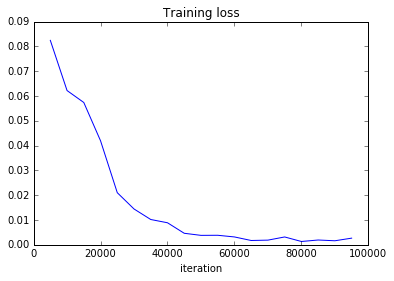

In [26]:
p1 = plt.figure(1)

legend(loc='lower right')
title('Training loss')
xlabel('iteration')

plot(losses_stack[:,0], losses_stack[:,1], label='rms')

savefig('losses_stack.png')
p1.show()

0.331949532032 1.0
[[3]
 [0]]
0.297677069902 0.87
[[7 5]
 [2 5]]
0.0662273019552 0.33
[[6 4 2]
 [6 4 4]]
9.10004018806e-05 0.0
[[2 9 6 3]
 [2 9 6 3]]
7.00687014614e-05 0.0
[[3 4 3 3 9]
 [3 4 3 3 9]]
7.38581948099e-05 0.0
[[3 7 7 9 7 5]
 [3 7 7 9 7 5]]
0.000112175686809 0.0
[[6 6 7 3 4 6 5]
 [6 6 7 3 4 6 5]]
0.000176044166437 0.0
[[2 2 6 7 5 5 3 7]
 [2 2 6 7 5 5 3 7]]
0.000341644423315 0.0
[[6 8 6 7 3 5 7 7 5]
 [6 8 6 7 3 5 7 7 5]]
0.00114779430442 0.002
[[8 3 4 5 2 2 8 2 5 5]
 [8 3 4 5 2 2 8 2 5 5]]
0.0142929907888 0.0672727272727
[[5 9 2 2 8 9 7 3 5 7 8]
 [5 9 2 2 8 9 7 3 5 7 7]]
0.0556941106915 0.1975
[[2 7 9 2 3 3 7 6 7 9 9 5]
 [2 7 9 2 3 3 7 3 3 9 9 5]]
0.0953286290169 0.288461538462
[[4 7 2 9 6 4 5 8 3 7 6 7 3]
 [4 7 2 9 6 4 6 6 2 5 5 7 3]]
0.130121469498 0.370714285714
[[9 3 5 6 3 9 9 6 3 7 5 3 8 2]
 [9 3 5 6 3 8 9 4 8 8 8 8 3 2]]
0.152076989412 0.417333333333
[[7 4 9 5 9 9 4 8 6 4 3 6 3 3 2]
 [7 4 9 5 9 9 4 3 6 3 8 3 3 3 2]]
0.174693346024 0.468125
[[9 2 4 2 4 9 4 7 2 7 2 3 7 3 

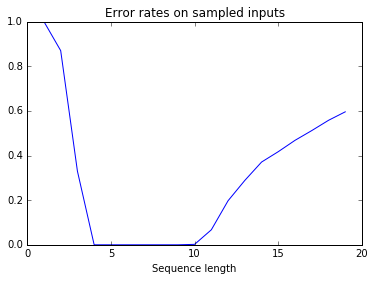

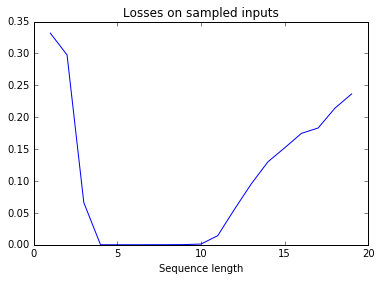

In [27]:
err_rates = []

test_seq_len = 20

for this_len in range(1, test_seq_len):
    Xc, Yc = gen_reverse_example(this_len, 100, 10)
    ret = copy_test_function(Xc, Yc)

    decoded_input = decode_matrix(Xc)
    decoded_target = decode_matrix(Yc)
    decoded_output = decode_matrix(copy_check_output(Xc).reshape(Xc.shape))
    
    err = (decoded_target.ravel() != decoded_output.ravel()).mean() * 2
    
    err_rates.append((this_len,) + tuple([ret, err]))

    print ret, err
    print vstack([decoded_target[:,0].ravel()[-this_len:], decoded_output[:,0].ravel()[-this_len:]])
    #print hstack([decoded_input, decoded_output])
    
    
    
errors_stack = np.array(err_rates)

p1 = plt.figure(3)

legend(loc='lower right')
title('Error rates on sampled inputs')
xlabel('Sequence length')

plot(errors_stack[:,0], errors_stack[:,2], label='err_rate')

savefig('errors_stack.png')
p1.show()

p2 = plt.figure(4)

legend(loc='lower right')
title('Losses on sampled inputs')
xlabel('Sequence length')

plot(errors_stack[:,0], errors_stack[:,1], label='loss')

savefig('losses_test_stack.png')
p2.show()

# LSTM Network

In [13]:
class CopyNet(Chain):
    def __init__(self, hidden_dim, num_layers=1,
                 **kwargs):
        super(CopyNet, self).__init__(**kwargs)
        self.recs = []
        
        for hid in xrange(num_layers):
            if hid == 0:
                in_dim = 10
            else:
                in_dim = hidden_dim
                
            rec = LSTM_RNN(in_dim=in_dim, hidden_dim=hidden_dim)
            
            self.recs.append(rec)
            self.children.append(rec)
        
        self.merge = MergeInputHiddens(
            in_dim=10, hidden_dim=hidden_dim,
            out_dim=10
            )
        self.children.append(self.merge)
        
        self.X = TT.tensor3('X')
        self.Y = TT.tensor3('Y')
        
        self.inputs = [self.X, self.Y]
    
    def apply(self, X):
        H = X
        for rec in self.recs:
            H = rec.apply(H)
            H = H[0] # we don't use cell contents
        O = self.merge.apply(X, H)
        
        return softmax(O)
    
    
    def get_loss(self):
        copy_net_output = self.apply(self.X)
        # return ((copy_net_output - self.Y)**2).mean() # MSE
        return -(self.Y * TT.log(copy_net_output)).mean() # cross entropy
    
    def get_output(self):
        copy_net_output = self.apply(self.X)
        return copy_net_output



In [14]:
theano.config.compute_test_value='off'
theano.config.print_test_value=True
debug = False

# Set the nubmer of hidden cells here. Note that intuitively you need more cells if you want to copy longer sequences. 
# The ratio 4 neurons per max seqence lenght seems to be fine.
copy_net = CopyNet(hidden_dim=80)
copy_net.initialize()
copy_net_loss = copy_net.get_loss()
copy_net_output = copy_net.get_output()

copy_test_function = theano.function(copy_net.inputs, 
                                       copy_net_loss)
copy_check_output = theano.function([copy_net.X], 
                                       copy_net_output)

In [15]:
copy_trainer = Trainer(copy_net_loss, copy_net.parameters, copy_net.inputs)

At each point in time, network receives an input of size 1x10 (1-hot encoding), propagets the signal through a layer of
hidden_dim LSTM neurons and produces an output of size 1x10 (also treated as 1-hot encoding). Softmax is applied at
the end to get calculated probabilities. Cross-entropy is used as a loss function.  

The problem we are solving is described in the following paper, section 5.1: http://arxiv.org/pdf/1511.06464v2.pdf.
The input is a seqeunce of size 2 * n + T and each element of the input is of one of the 10 classes, which will name by the numbers from 0 to 9. First n elements is an arbitrary sequence of numbers 2...9. Then, T - 1 '0's follow. The next element is a single '1' and the last n elements are '0's. The desired output is a sequence of the same length, where the first T + n elemtnts are '0's followed by sequence from the beginnig of the input. The kth element of the output should be produced after the net sees the kth element of the input.

The difficulty of the task is the fact that a network has to put elements in the memory, store them for a long time and then reproduce them. 

In the cited paper authors used n = 10 (length of the sequence to reproduce) and 40 neurons. Their network was only a little bit better than baseline (a program that outputs T + n '0's and n random numbers) when T = 100 and did not learn at all for larger T.

It tunrs out that this task is in fact easy with the use of curriculum. My network was able to learn to perfectly reproduce the sequence with the time lag of 400.

The curriculum is used both for the n (seq_len) as well as T (lag). In every consecutive batch the lag is of random size. As the newtork get better, we increase both the maximium allowed lag, as well as the sequnece lenght. After the training, the net should be able to copy a sequence of any length over any time lag not greater than the learnt ones. 

In [19]:
copy_net.initialize()

# Feel free to tune the learing rate, this one worked the best for me. 
# We don't use any learing scheuling (lrate is constant), as every time the net starts getting closer to optimum, 
# we just make the problem harder (increasse the time lag) instead of trying to find the optimum more accurately
# I tried using learing rate scheduling, without any noticable iprovement

lrate = 1e-3
copy_trainer.lrate.set_value(lrate)

# Set weight decay, it seems to be helpful
copy_trainer.wdec.set_value(1e-6)

losses = []

seq_len = 10
max_it = 100000

for i in xrange(max_it):
    this_len = randint(4, seq_len + 1)
    Xc, Yc = gen_reverse_example(this_len, 32,10)
    ret = copy_trainer.train_function(Xc, Yc)
    
    if i%5000 == 0:
        Xc, Yc = gen_reverse_example(seq_len, 32, 10)
        ret = copy_test_function(Xc, Yc)
        print i, ret
        if i != 0: #ignore noisy start
            losses.append((i,) + tuple([ret]))
        decoded_target = decode_matrix(Yc)
        decoded_output = decode_matrix(copy_check_output(Xc).reshape(Xc.shape))
        
        # Sanity check
        # print decode_matrix(Xc)
        # print decode_matrix(Yc)
        # print decoded_output
        print vstack([decoded_target[:,0].ravel()[-seq_len:], decoded_output[:,0].ravel()[-seq_len:]])

        
# print charts

losses_lstm = np.array(losses)
                                 
'''
p1 = plt.figure(1)

legend(loc='lower right')
title('Training loss')
xlabel('iteration')

plot(losses_a[:,0], losses_a[:,1], label='rms')

savefig('losses_small.png')
p1.show()
'''
#semilogy(losses_a[:,0], losses_a[:,2], label='rms + wdec')
#semilogy(losses_a[:,0], losses_a[:,2], label='rms')
#plot(losses_a[:,0], losses_a[:,3], label='grad norm')

0 0.251907110214
[[3 9 6 7 7 2 6 7 9 3]
 [8 8 8 8 8 8 3 3 6 6]]
5000 0.0863210856915
[[8 7 2 3 3 6 6 3 8 2]
 [8 6 8 6 8 2 8 2 8 2]]
10000 0.0747941359878
[[5 4 6 5 8 5 8 2 9 2]
 [5 6 8 6 8 8 8 2 9 2]]
15000 0.0641732960939
[[6 8 5 3 3 7 8 3 5 6]
 [6 8 5 3 3 3 3 3 5 5]]
20000 0.0551476292312
[[5 5 7 3 3 8 4 8 3 9]
 [5 5 3 8 3 8 3 9 9 9]]
25000 0.0389163531363
[[6 8 6 4 9 5 5 7 2 9]
 [6 8 6 4 5 5 5 4 2 9]]
30000 0.0379168987274
[[2 5 4 8 9 5 4 2 9 9]
 [2 8 4 8 9 5 2 9 9 9]]
35000 0.0334496833384
[[8 2 3 2 6 9 3 7 7 7]
 [8 2 3 2 3 2 6 2 7 7]]
40000 0.0346318930387
[[6 7 3 9 9 2 4 4 3 3]
 [6 7 3 9 9 9 4 4 3 3]]
45000 0.0225064083934
[[9 6 4 8 4 5 8 4 6 4]
 [9 4 4 8 4 4 7 6 6 4]]
50000 0.0171636808664
[[4 3 3 5 5 9 8 7 8 8]
 [4 3 3 5 5 9 8 7 8 8]]
55000 0.0175776164979
[[2 8 6 4 5 9 6 4 4 2]
 [2 8 6 4 5 9 6 4 4 2]]
60000 0.0126734841615
[[5 2 8 8 2 2 4 3 7 9]
 [5 2 8 8 2 2 4 3 7 9]]
65000 0.015734706074
[[2 6 9 9 2 5 5 6 4 5]
 [2 6 9 9 2 5 5 6 4 5]]
70000 0.0123683391139
[[2 8 5 4 8 6 3 5 5

"\np1 = plt.figure(1)\n\nlegend(loc='lower right')\ntitle('Training loss')\nxlabel('iteration')\n\nplot(losses_a[:,0], losses_a[:,1], label='rms')\n\nsavefig('losses_small.png')\np1.show()\n"

Now let's wee what the trained network can do.

/pio/os/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/pio/os/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


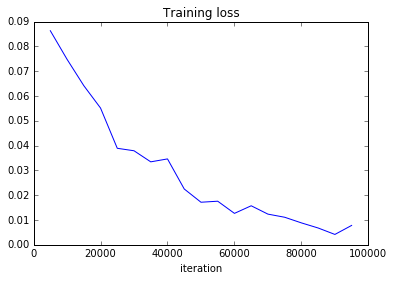

In [20]:
p1 = plt.figure(1)

legend(loc='lower right')
title('Training loss')
xlabel('iteration')

plot(losses_lstm[:,0], losses_lstm[:,1], label='rms')

savefig('losses_lstm.png')
p1.show()

0.0354810990393 0.15
[[6]
 [3]]
0.0383739434183 0.25
[[3 6]
 [3 7]]
0.00159658119082 0.00333333333333
[[5 5 8]
 [5 5 8]]
0.000392412592191 0.0
[[5 2 6 2]
 [5 2 6 2]]
0.000365945976228 0.0
[[2 9 4 7 3]
 [2 9 4 7 3]]
0.000440806761617 0.0
[[7 7 4 5 6 9]
 [7 7 4 5 6 9]]
0.000625580607448 0.0
[[4 4 5 5 9 7 9]
 [4 4 5 5 9 7 9]]
0.000988467829302 0.00125
[[2 5 7 5 7 6 4 5]
 [2 5 7 5 7 6 4 5]]
0.00180917489342 0.00333333333333
[[2 6 3 5 8 6 7 3 9]
 [2 6 3 5 8 6 7 3 9]]
0.00474569760263 0.025
[[7 2 5 8 8 8 4 8 9 2]
 [7 2 5 8 8 8 4 8 9 2]]
0.0146804526448 0.0909090909091
[[7 8 7 2 5 5 7 5 4 5 3]
 [7 8 7 2 5 5 7 5 4 5 3]]
0.0351623557508 0.21
[[8 2 9 4 7 3 7 8 2 7 4 3]
 [8 2 2 3 7 3 2 8 2 7 7 3]]
0.0584356896579 0.305384615385
[[9 8 3 7 4 7 4 7 2 2 9 9 6]
 [9 8 3 7 2 7 6 2 2 9 2 3 5]]
0.0855603665113 0.387857142857
[[9 9 4 7 3 2 8 3 4 2 7 8 7 2]
 [9 9 4 7 2 2 8 2 2 2 2 2 7 8]]
0.10736130178 0.454
[[4 3 5 4 7 8 9 2 3 9 7 9 8 7 9]
 [4 3 5 4 2 8 9 8 2 9 9 9 8 9 8]]
0.129564374685 0.5175
[[3 6 7 2 7

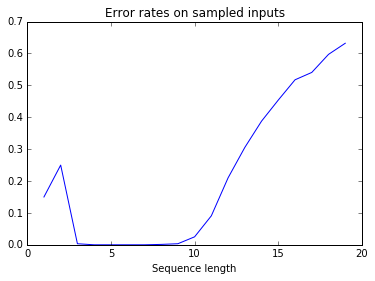

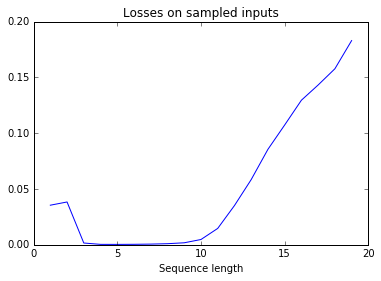

In [21]:
err_rates = []

test_seq_len = 20

for this_len in range(1, test_seq_len):
    Xc, Yc = gen_reverse_example(this_len, 100, 10)
    ret = copy_test_function(Xc, Yc)

    decoded_input = decode_matrix(Xc)
    decoded_target = decode_matrix(Yc)
    decoded_output = decode_matrix(copy_check_output(Xc).reshape(Xc.shape))
    
    err = (decoded_target.ravel() != decoded_output.ravel()).mean() * 2
    
    err_rates.append((this_len,) + tuple([ret, err]))

    print ret, err
    print vstack([decoded_target[:,0].ravel()[-this_len:], decoded_output[:,0].ravel()[-this_len:]])
    #print hstack([decoded_input, decoded_output])
    
    
    
errors_lstm = np.array(err_rates)

p1 = plt.figure(3)

legend(loc='lower right')
title('Error rates on sampled inputs')
xlabel('Sequence length')

plot(errors_lstm[:,0], errors_lstm[:,2], label='err_rate')

savefig('errors_lstm.png')
p1.show()

p2 = plt.figure(4)

legend(loc='lower right')
title('Losses on sampled inputs')
xlabel('Sequence length')

plot(errors_lstm[:,0], errors_lstm[:,1], label='loss')

savefig('losses_test_lstm.png')
p2.show()